# Hello, Slicer!

Let's test that the setup was successful by checking that:

1. We're running the python kernel bundled with Slicer
2. The python kernel actually works
3. We have access to Slicer functionality


In [2]:
import sys
print(f'We\'re running {sys.executable}\n')
print("Hello, Slicer!")

We're running /Applications/MedicalImaging/Slicer.app/Contents/bin/PythonSlicer

Hello, Slicer!


In [3]:
try:
    import vtk
    import numpy as np
    from emoji import UNICODE_EMOJI
    import JupyterNotebooksLib as slicernb
    print('Imports succeeded. Slicer environment is setup correctly.')
except ImportError as e:
    print(f'Imports failed with the following message: {e}.\nSlicer environment was not setup correctly.')

Imports succeeded. Slicer environment is setup correctly.


---

## Great!

Now that we have everything setup and python is working let's try to create and view some objects in Slicer.

Let's create a function that generates a cube:

In [4]:
def create_cube(size_xyz: list, center_xyz: list) -> vtk.vtkCubeSource:
    """
    Creates a cube of a given size at a given point.

    :param      size_xyz:    List specifying size [x,y,z].
    :type       size_xyz:    list
    :param      center_xyz:  List specifying centroid coordinated [x,y,z].
    :type       center_xyz:  list

    :returns:   A VKT box.
    :rtype:     vtkCubeSource
    """
    box = vtk.vtkCubeSource()
    box.SetXLength(size_xyz[0])
    box.SetYLength(size_xyz[1])
    box.SetZLength(size_xyz[2])
    box.SetCenter(center_xyz)
    return box

Now let's generate some cubes

In [5]:
some = 5  # why not?

for i in range(some):
    box = create_cube(np.random.randint(1, 42, 3).tolist(),
                      np.random.randint(-50, 50, 3).tolist())

    # Create a model node that displays our box
    boxNode = slicer.modules.models.logic().AddModel(box.GetOutputPort())
    boxNode.SetName(f'Box{str(i+1)}')

    # Adjust display properties (color and opacity)
    boxNode.GetDisplayNode().SetColor(np.random.sample(3))
    boxNode.GetDisplayNode().SetOpacity(np.random.uniform(0, 1))

And let's adjust the 3D viewport camera position to render our cubes in the notebook output.

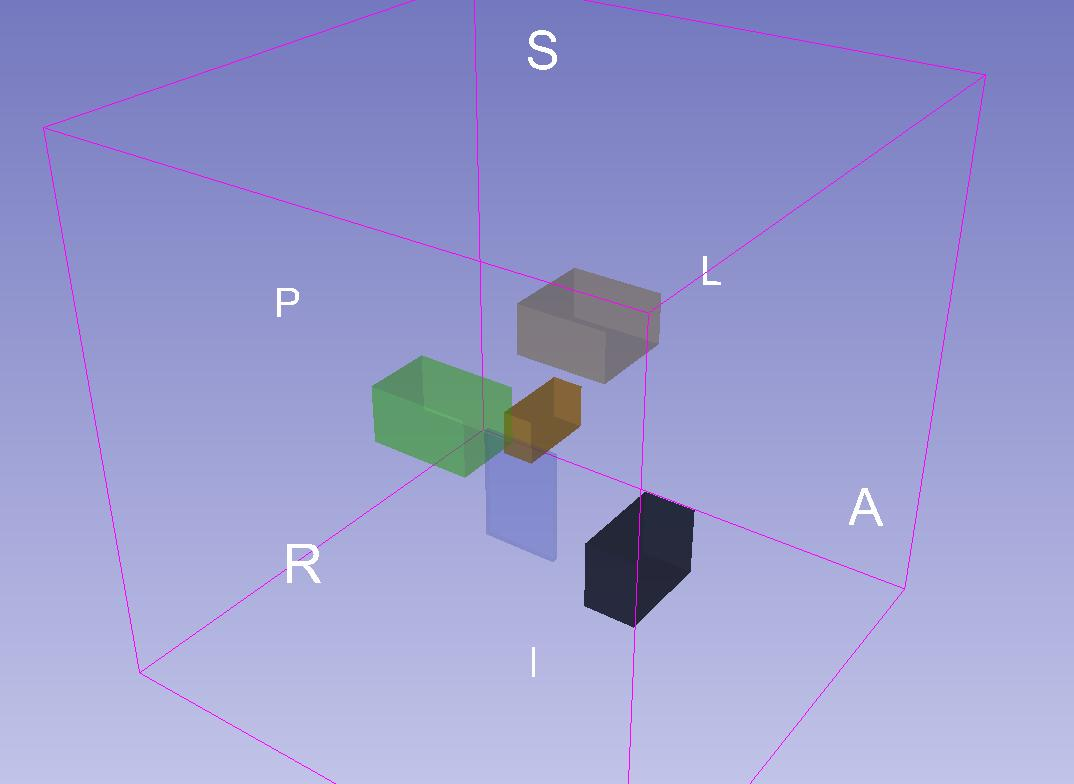

In [6]:
lm = slicer.app.layoutManager()
view = lm.threeDWidget(0).threeDView()
threeDViewNode = view.mrmlViewNode()
cameraNode = slicer.modules.cameras.logic().GetViewActiveCameraNode(threeDViewNode)
cameraNode.SetPosition([342,242,242])
slicernb.View3DDisplay()

## Nice!

So we've tested that VTK is in place and that the 3D view works. What about the slice views?

---

## Let's create some images to display them in slice views.

We'll create a "💀 Hello Slicer" sign spanned across the Red, Green and Yellow slice views.

Let's start with creating images represented as numpy arrays

In [7]:
def create_np_text_img(text: str, size: tuple = (128, 128)) -> np.ndarray:
    """
    Creates a numpy text image.

    Creates a text-on-background image and returns it as a flat 3D numpy array.
    
    Check font paths when copying this function.
    The font paths should point to actual true-type font files on the disk.

    :param      text:  Input unicode text.
    :type       text:  str
    :param      size:  Target image size (optional).
    :type       size:  tuple

    :returns:   Flat 3D numpy array containing pixel values.
    :rtype:     np.ndarray
    """
    from PIL import Image, ImageDraw, ImageFont
    if bool(set(text).intersection(UNICODE_EMOJI)):
        font_path = "/System/Library/Fonts/Apple Color Emoji.ttc"
        font = ImageFont.truetype(font_path, 64)
    else:
        font_path = "/System/Library/Fonts/Microsoft/Arial Black.ttf"
        font = ImageFont.truetype(font_path, 24)

    text_width, text_height = font.getsize(text)

    text_image = Image.new('I', size, "black")
    draw = ImageDraw.Draw(text_image)
    draw.text((text_width/2, text_height/2), text, 'white', font)
    return np.asarray(text_image).reshape(*size, 1)

In [8]:
skull_image_array = create_np_text_img('💀')
hello_image_array = create_np_text_img('Hello')
slicer_image_array = create_np_text_img('Slicer')

The coordinate space of the images, the arrays and slice views is usually not the same. 
There is a good wiki article about it here:

[https://www.slicer.org/wiki/Coordinate_systems](https://www.slicer.org/wiki/Coordinate_systems)

That means that displaying our sign in the slice views might require some rotations and flipping.

Let's create an empty (128, 128, 128) array and paste our images onto it's sides.

In [9]:
volume = np.zeros((128, 128, 128))

volume[:1, :, :] = np.rot90(skull_image_array, 2, (0, 1)).transpose(2, 0, 1)
volume[:, :1, :] = np.rot90(hello_image_array[::-1], 1, (0, 1)).transpose(1, 2, 0)
volume[:, :, :1] = np.rot90(slicer_image_array, 2, (0, 1))

Finally we can create a volume node and render it's slices in the slice views

In [10]:
volumeNode = slicer.util.addVolumeFromArray(volume)
volumeNode.SetName('Hello Slicer!')

In [11]:
def show_slice_in_slice_view(volumeNode: slicer.vtkMRMLScalarVolumeNode,
                             sliceNum: int = 0,
                             sliceView: str = 'Red'):
    """
    Render a numpy image on slice view.

    :param      volumeNode:  The volume node
    :type       volumeNode:  vtkMRMLScalarVolumeNode
    :param      sliceNum:    The number of the slice that we want to show. Optional. Defaults to 0.
    :type       sliceNum:    int
    :param      sliceView:   One of default slice views ('Red', 'Green', 'Yellow')
    :type       sliceView:   str
    """
    sliceViewWidget = slicer.app.layoutManager().sliceWidget(sliceView)
    sliceWidgetLogic = sliceViewWidget.sliceLogic()
    sliceWidgetLogic.GetSliceCompositeNode().SetForegroundVolumeID(volumeNode.GetID())
    sliceWidgetLogic.FitSliceToAll()
    sliceWidgetLogic.SetSliceOffset(sliceNum)
    pass

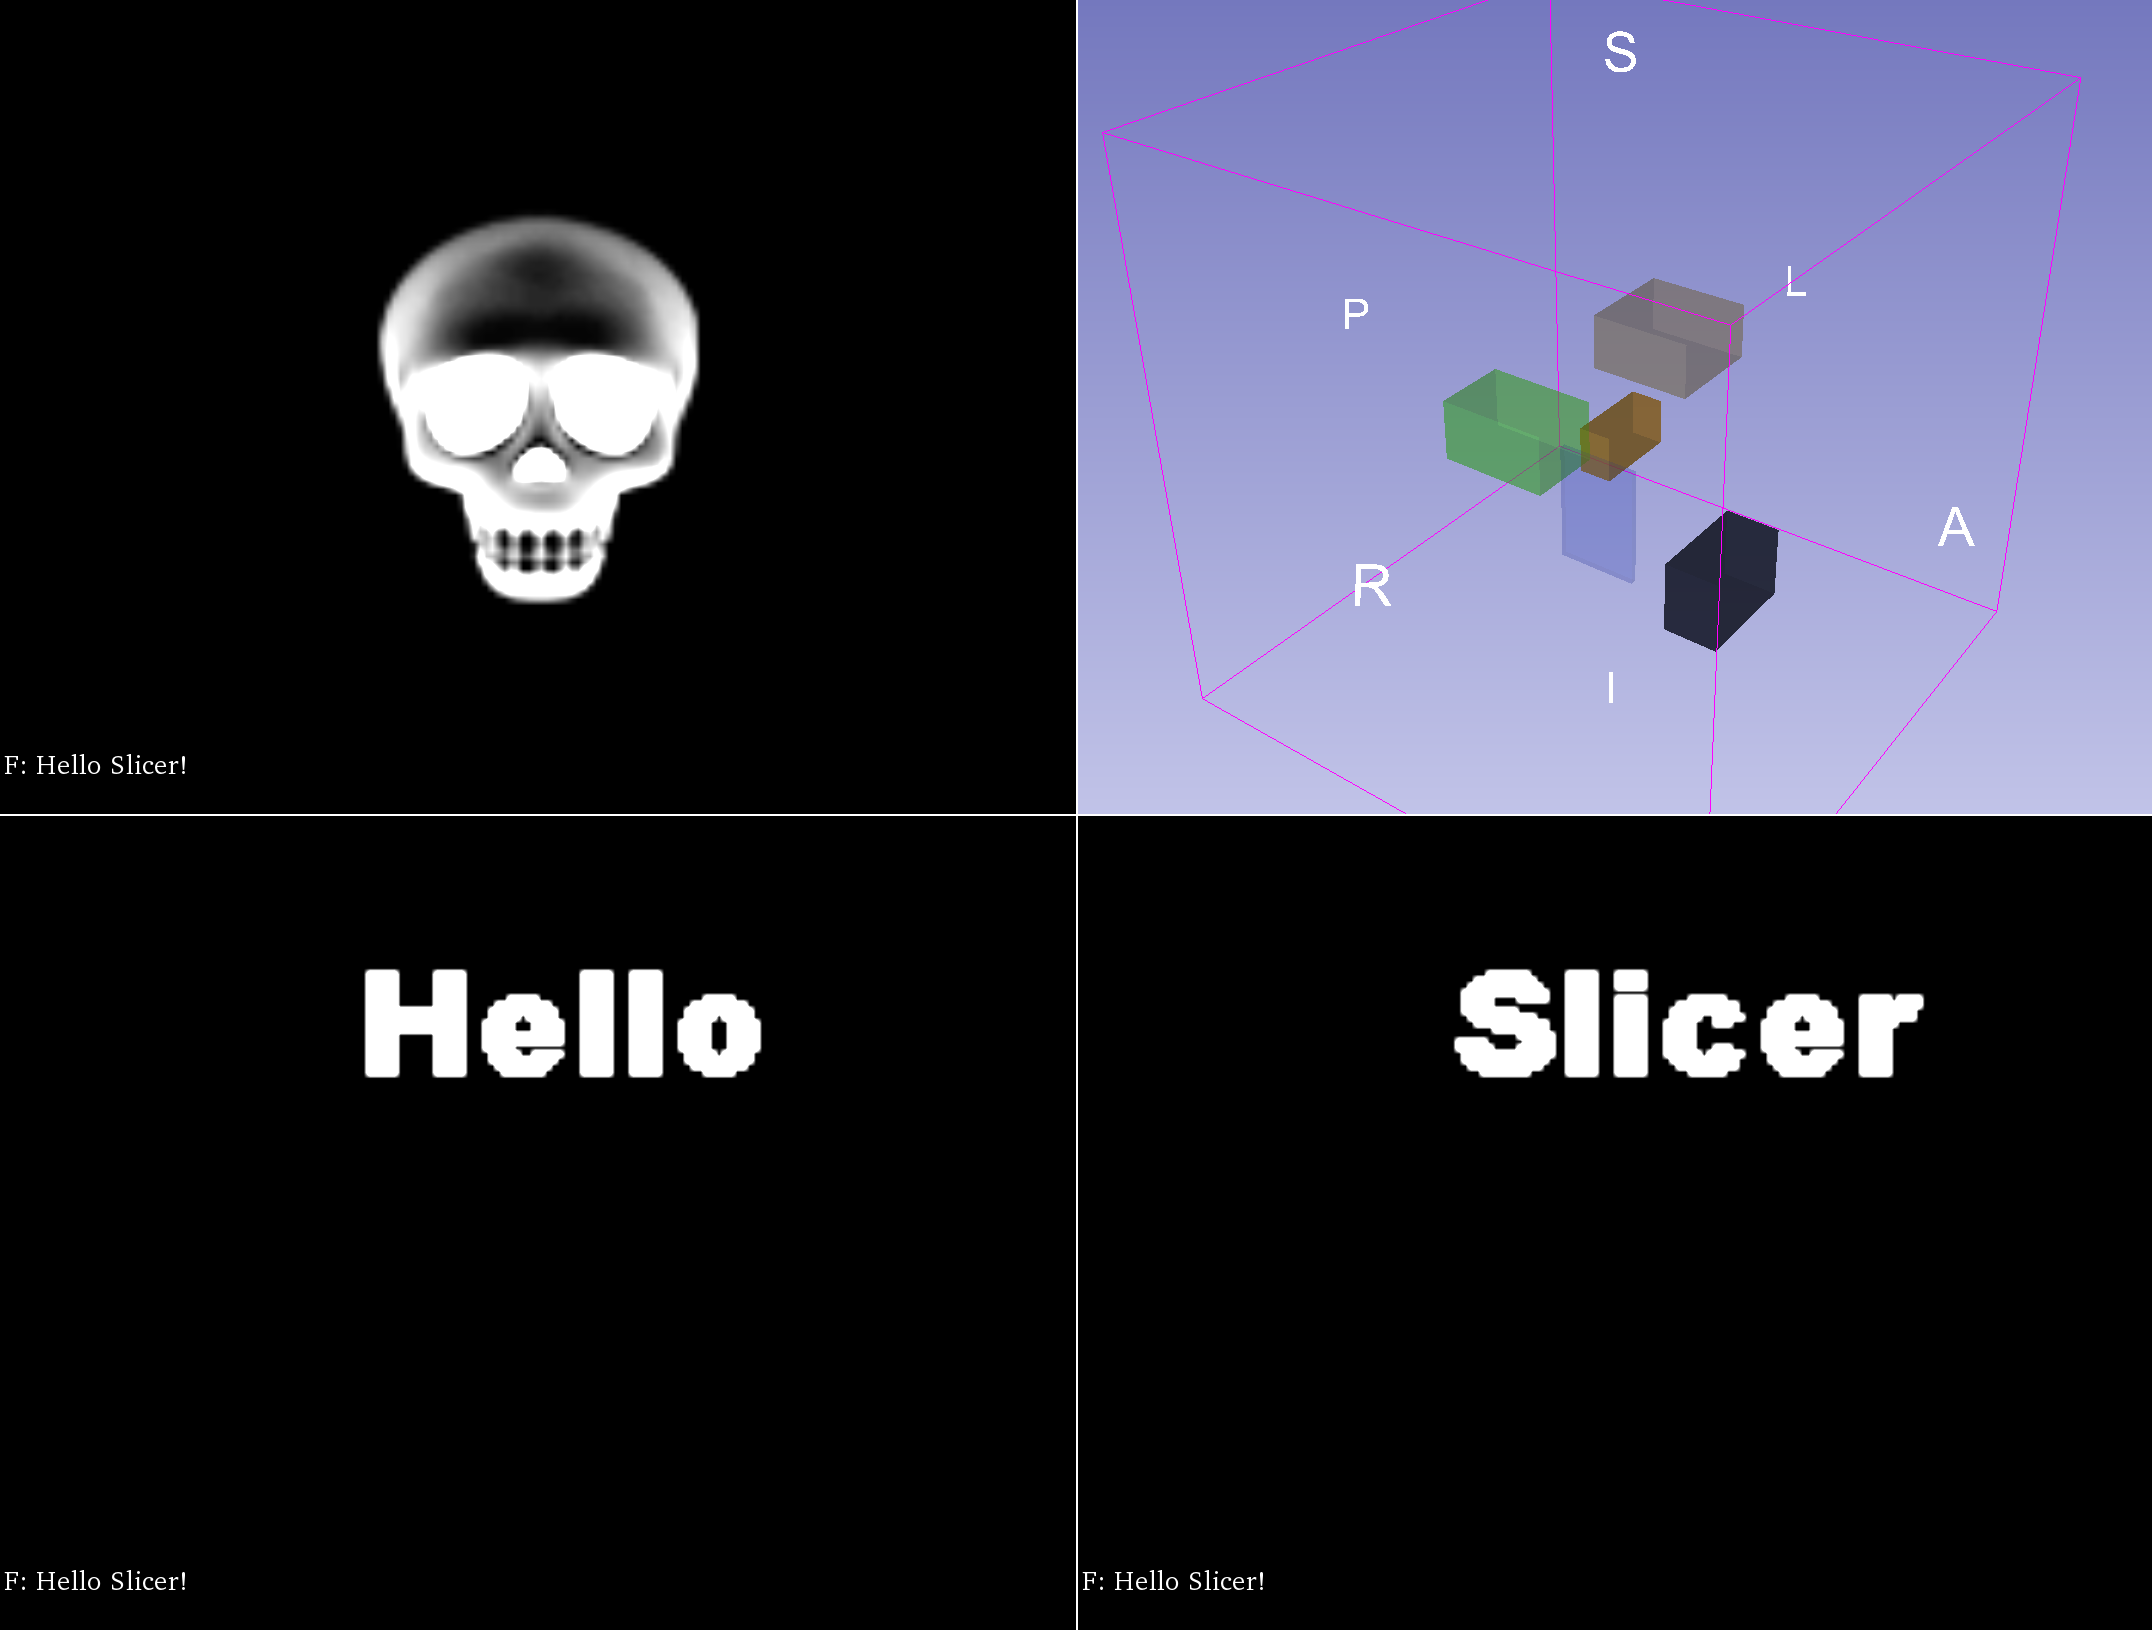

In [12]:
for sliceView in ['Red', 'Green', 'Yellow']:
    show_slice_in_slice_view(volumeNode, 0, sliceView)
slicernb.ViewDisplay('FourUp', False)

# All right! This was fun!

Let's play with volumes a bit more in the next notebook.